# Построение PD модели  
Выполнил Бадеев Илья  
Скор на приват датасете - 0.62

# Загрузка датасета и первичный взгляд на данные

In [2031]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
import warnings
import eli5
warnings.filterwarnings('ignore')
sns.set_style('dark')

In [2032]:
train_df = pd.read_csv('PD-data-train.csv', sep=';')
test_df = pd.read_csv('PD-data-test.csv', sep=';')
desc_df = pd.read_csv('PD-data-desc.csv', sep=';')

In [2033]:
train_df.head()

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,...,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg,default_12m
0,7,52996000.0,48344000.0,48344000.0,0.0,0.0,4652000.0,-2608000.0,2044000.0,846000.0,...,3,3,3,[1-100],50000.0,2,0,0,0,0
1,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12,12,12,[1-100],10000.0,5,0,0,0,0
2,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,28,28,28,[1-100],10000.0,2,0,0,0,0
3,22,32049000.0,29568000.0,29568000.0,0.0,0.0,2481000.0,-260000.0,2221000.0,302000.0,...,8,8,8,[1-100],300000.0,1,0,0,0,0
4,23,16458000.0,14935000.0,14935000.0,0.0,0.0,1523000.0,-274000.0,1249000.0,538000.0,...,27,27,27,[1-100],10000.0,2,0,0,0,0


In [2034]:
desc_df

,field,desc_eng,desc_rus
0,ar_revenue,Sales revenue (at the end of the last year),Выручка от реализации (на конец последнего года)
1,ar_total_expenses,Total expenses for the last year,Общие расходы за последний год
2,ar_sale_cost,Cost of sales (at the end of the last year),Себестоимость продаж (на конец последнего года)
3,ar_selling_expenses,Selling expenses (at the end of the last year),Коммерческие расходы (на конец последнего года)
4,ar_management_expenses,Administrative expenses (at the end of the las...,Управленческие расходы (на конец последнего года)
5,ar_sale_profit,Profit from sales (at the end of the last year),Прибыль от реализации (на конец последнего года)
6,ar_balance_of_rvns_and_expns,Balance of income and expenses (at the end of ...,Баланс доходов и расходов (на конец последнего...
7,ar_profit_before_tax,Gross Profit (end of last year),Валовая прибыль (на конец последнего года)
8,ar_taxes,Current income tax (at the end of the last year),Текущий на налог на прибыль (на конец последне...
9,ar_other_profit_and_losses,Other income and expenses (at the end of the l...,Прочие доходы и расходы (на конец последнего г...


In [2035]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32395 entries, 0 to 32394
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   record_id                     32395 non-null  int64  
 1   ar_revenue                    17250 non-null  float64
 2   ar_total_expenses             17250 non-null  float64
 3   ar_sale_cost                  17250 non-null  float64
 4   ar_selling_expenses           17250 non-null  float64
 5   ar_management_expenses        17250 non-null  float64
 6   ar_sale_profit                17250 non-null  float64
 7   ar_balance_of_rvns_and_expns  17250 non-null  float64
 8   ar_profit_before_tax          17250 non-null  float64
 9   ar_taxes                      17250 non-null  float64
 10  ar_other_profit_and_losses    17250 non-null  float64
 11  ar_net_profit                 17250 non-null  float64
 12  ab_immobilized_assets         17250 non-null  float64
 13  a

In [2036]:
# Видно, что практически у половины датасета есть NaN значения у определенных фичей. Данные фичи 
# включают в себя финансовые показатели компании, и тогда понятно что если это ИП, то их просто не будет.
# Думаю будет разумно в дальнейшем разделить данные на две модели для обучения.

In [2037]:
train_df.describe()

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,...,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg,default_12m
count,32395.000000,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,...,32395.000000,32395.000000,32395.000000,32395.000000,3.239500e+04,32395.000000,32395.000000,32395.000000,32395.0,32395.000000
mean,136955.533601,8.153776e+07,7.678474e+07,7.320328e+07,2.499198e+06,1.082263e+06,4.753016e+06,-6.424773e+05,4.110538e+06,4.188071e+05,...,78.644822,15.010341,15.010341,15.010341,1.366509e+06,11.946535,0.021670,0.000093,0.0,0.064547
std,79370.573366,1.274402e+08,1.227227e+08,1.156651e+08,1.231798e+07,7.848929e+06,1.941027e+07,6.014715e+06,1.938021e+07,1.565298e+06,...,46.522534,9.546511,9.546511,9.546511,1.502438e+07,86.341847,0.342715,0.009623,0.0,0.245729
min,7.000000,0.000000e+00,-7.019840e+08,-5.072780e+08,-3.542900e+07,-1.921670e+08,-9.210000e+07,-7.581800e+07,-5.946600e+07,-1.681000e+07,...,0.000000,1.000000,1.000000,1.000000,0.000000e+00,1.000000,0.000000,0.000000,0.0,0.000000
25%,67912.000000,1.019950e+07,9.130250e+06,8.844000e+06,0.000000e+00,0.000000e+00,2.112500e+05,-9.400000e+05,1.420000e+05,0.000000e+00,...,35.000000,6.000000,6.000000,6.000000,1.000000e+04,1.000000,0.000000,0.000000,0.0,0.000000
50%,137527.000000,3.233500e+07,2.970350e+07,2.840800e+07,0.000000e+00,0.000000e+00,1.231500e+06,-1.260000e+05,8.500000e+05,4.100000e+04,...,77.000000,14.000000,14.000000,14.000000,1.000000e+04,1.000000,0.000000,0.000000,0.0,0.000000
75%,205633.500000,8.887675e+07,8.309500e+07,7.991425e+07,0.000000e+00,0.000000e+00,4.574750e+06,0.000000e+00,3.543750e+06,2.910000e+05,...,133.000000,24.000000,24.000000,24.000000,3.000000e+04,2.000000,0.000000,0.000000,0.0,0.000000
max,274623.000000,7.946840e+08,7.949360e+08,7.624930e+08,2.746560e+08,3.023550e+08,1.434511e+09,1.584250e+08,1.481526e+09,5.420200e+07,...,149.000000,33.000000,33.000000,33.000000,1.584979e+09,998.000000,20.000000,1.000000,0.0,1.000000


In [2038]:
# Из самых стандартных статистических показателей видно,что в данных значительное значение выбросов,
# так как многие максимальные значения отличаются от 75% квантили на 4-5 порядков. Также обратим внимание
# на фичи ul_strategic_flg и ul_systematizing_flg. В первом крайне малое количество единиц, далее 
# посмотрим на специфику их распределения, а второй можно смело удалять, он не принесет никакой пользы
# модели.

# Предобработка всего датасета и добавление новых фич

In [2039]:
# Проверим дубликаты и при необходимости удалим их.
drop_col = train_df.drop('record_id', axis=1).columns
train_df[train_df.duplicated(subset=drop_col)]

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,...,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg,default_12m
137,1043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13,13,13,[1-100],10000.0,1,0,0,0,0
456,3924,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3,3,3,[1-100],10000.0,1,0,0,0,0
489,4141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16,16,16,[1-100],10000.0,2,0,0,0,0
496,4181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16,16,16,[1-100],10000.0,1,0,0,0,0
516,4348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9,9,9,[1-100],10000.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32377,274484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5,5,5,[1-100],10000.0,1,0,0,0,0
32378,274489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23,23,23,[1-100],10000.0,1,0,0,0,0
32380,274497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24,24,24,[1-100],10000.0,1,0,0,0,0
32384,274530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,2,2,[1-100],10000.0,1,0,0,0,0


In [2040]:
# Я решил удалить дубликаты так как из наличие в большинстве логически необосновано, и также с ними
# скор модели и коэф. Джини меньше
train_df.drop_duplicates(subset=drop_col, inplace=True)
train_df.reset_index(inplace=True, drop=True)

In [2041]:
# Добавим несколько относительных фичей которые будут демонстрировать основные финансовые показатели 
# компаний. Для этого сначала соеденим наши треин тест выборки
df_all = pd.concat([train_df.drop('default_12m', axis=1), test_df]).reset_index(drop=True)
# Определим переменную, включающую все обязательства компании
TL = df_all.ab_long_term_liabilities + df_all.ab_other_borrowings + df_all.ab_short_term_borrowing
# Теперь добавим новые фичи
# Валовая рентабельность
df_all['my_GPM'] = (df_all.ar_revenue - df_all.ar_sale_cost)/df_all.ar_revenue
# Маржа чистой прибыли
df_all['my_NPM'] = df_all.ar_net_profit/df_all.ar_revenue
# Коэффициент текущей леквидности
df_all['my_CR'] = df_all.ab_mobile_current_assets/df_all.ab_short_term_borrowing
# Коэффициент срочной ликвидности
df_all['my_QR'] = (df_all.ab_mobile_current_assets - df_all.ab_inventory)/df_all.ab_short_term_borrowing
# Коэффициетн автономии
df_all['my_A'] = df_all.ab_own_capital/(df_all.ab_own_capital + df_all.ab_borrowed_capital)
# Коэффициент соотношения собственных и заемных средств
df_all['my_SL_C'] = df_all.ab_short_term_borrowing/df_all.ab_own_capital
# Коэффициент краткосрочной задолженности
df_all['my_SL'] = df_all.ab_short_term_borrowing/TL
# Коэффициент налогооблажения
df_all['my_Tax'] = df_all.ar_profit_before_tax/df_all.ar_net_profit

In [2042]:
# Посмотрим на наши новые фичи
df_all.loc[:, 'my_GPM':]

,my_GPM,my_NPM,my_CR,my_QR,my_A,my_SL_C,my_SL,my_Tax
0,0.087780,0.022605,0.637942,0.198432,0.040097,17.117647,1.00000,1.706177
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.077413,0.059877,1.162377,0.044633,0.377959,1.645786,1.00000,1.157374
4,0.092539,0.043201,inf,inf,0.906765,0.000000,NaN,1.756681
...,...,...,...,...,...,...,...,...
26785,0.237704,0.086579,inf,inf,0.397199,0.000000,0.00000,1.262073
26786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26788,0.272864,0.011350,2.324837,1.233307,0.286078,0.795118,0.40632,1.050029


In [2043]:
# Очевидно что у нас могли возникнуть inf, ведь мы же делили, и никто не исключал ноль. Заменим inf -> 0
df_all.replace([np.inf, -np.inf], 0, inplace=True)

In [2044]:
# Можно заметить, что у нас есть один категориальный признак. Посмотрим какие различные значения он принимает 
df_all['ul_staff_range'].unique()

array(['[1-100]', '(100-500]', '> 500'], dtype=object)

In [2045]:
# Данные признак имеет порядок, поэтому можно просто заменить значения на целые
pattern ={
    '[1-100]': 0,
    '(100-500]': 1,
    '> 500': 2
}
df_all['ul_staff_range'] = [pattern[x] for x in df_all['ul_staff_range']]

In [2046]:
df_all['ul_staff_range']

0        0
1        0
2        0
3        0
4        0
        ..
26785    0
26786    0
26787    0
26788    0
26789    0
Name: ul_staff_range, Length: 26790, dtype: int64

In [2047]:
# Как и оговаривалось ранее, удалим фичу ul_systematizing_flg и разделим данные обратно на треин тест
df_all.drop('ul_systematizing_flg', axis=1, inplace=True)
df_proc_train = df_all.iloc[:-200]
df_proc_test = df_all.iloc[-200:].reset_index(drop=True)
df_proc_train = pd.concat([df_proc_train, train_df['default_12m']], axis=1).reset_index(drop=True)

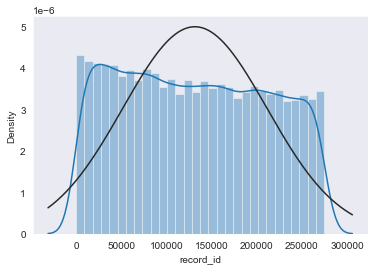

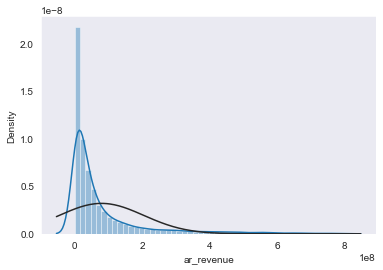

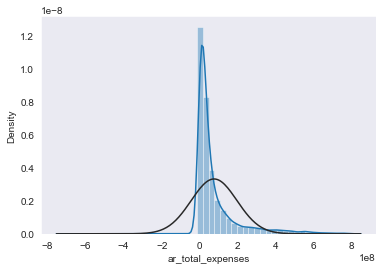

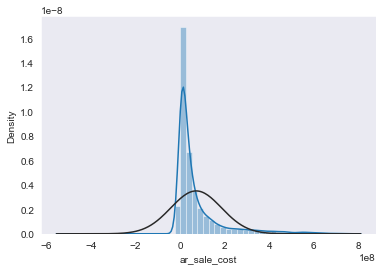

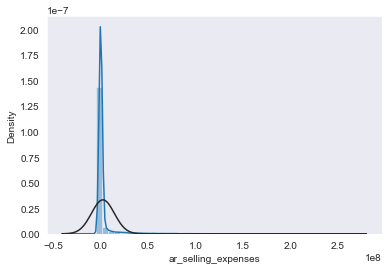

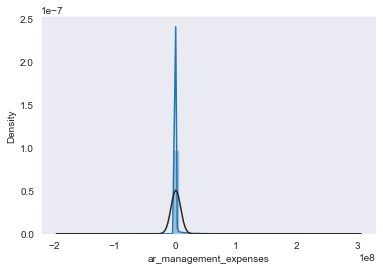

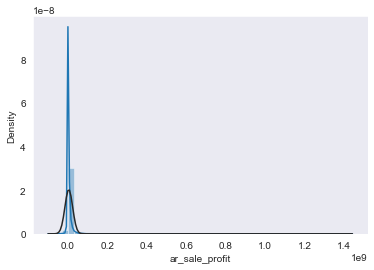

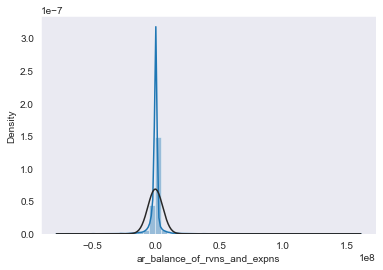

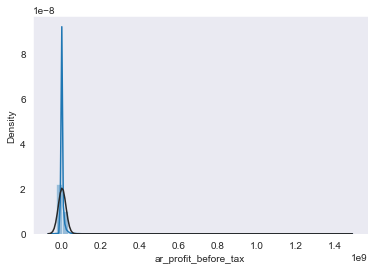

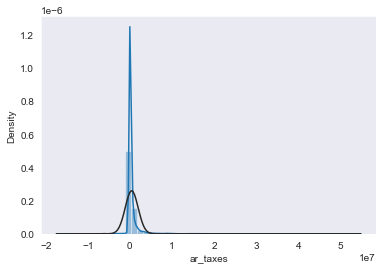

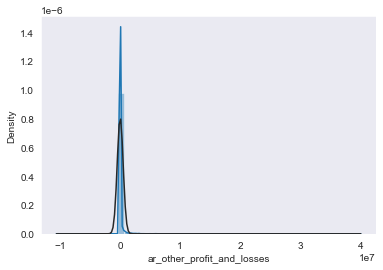

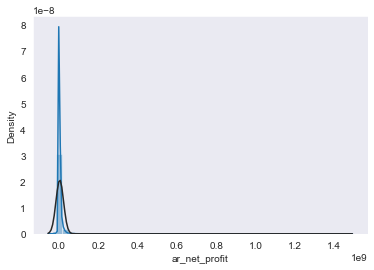

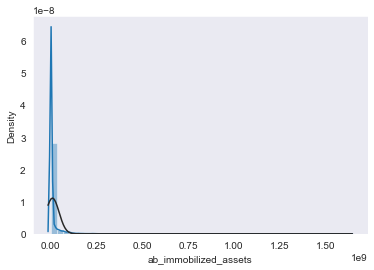

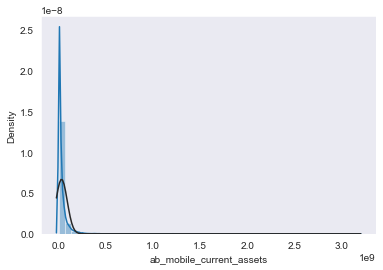

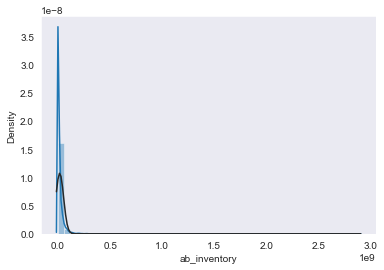

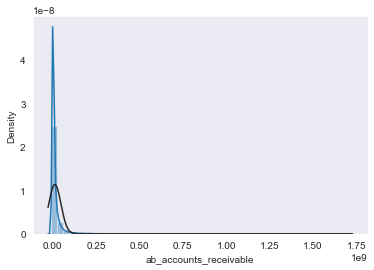

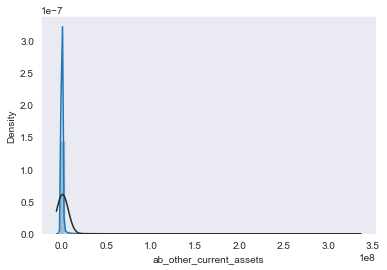

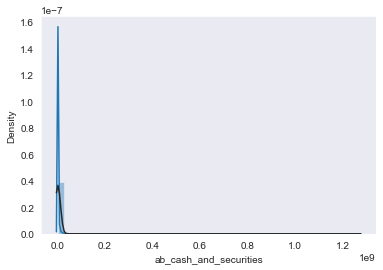

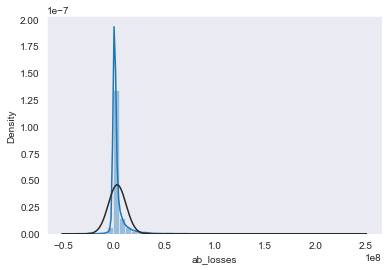

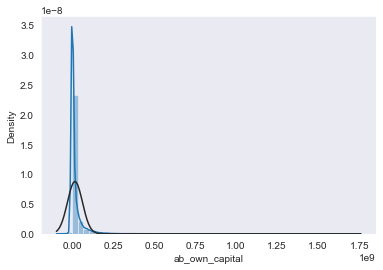

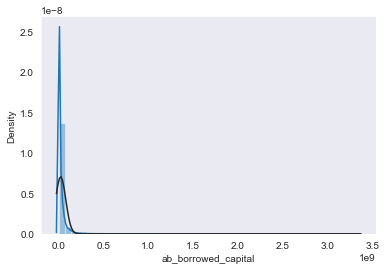

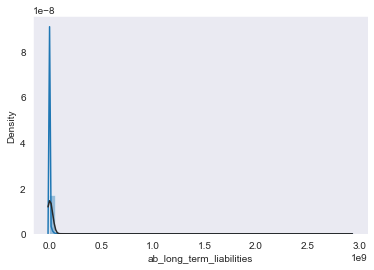

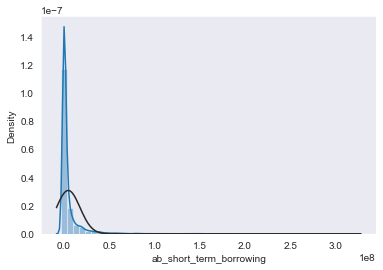

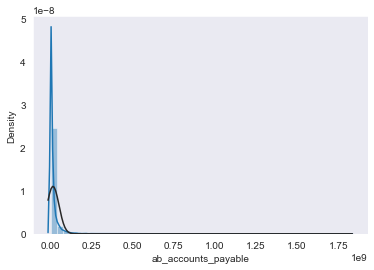

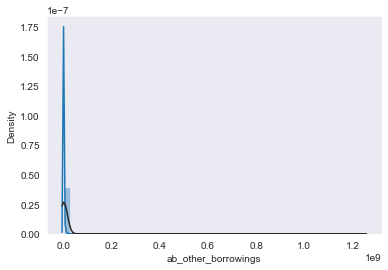

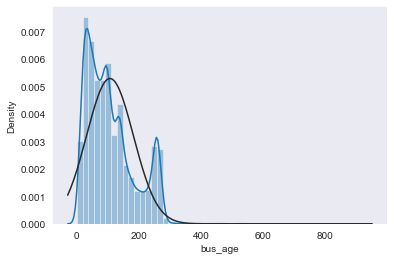

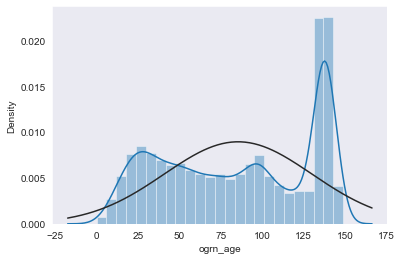

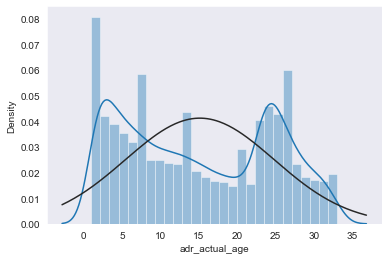

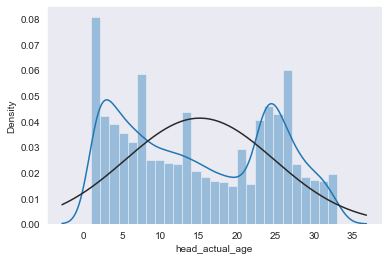

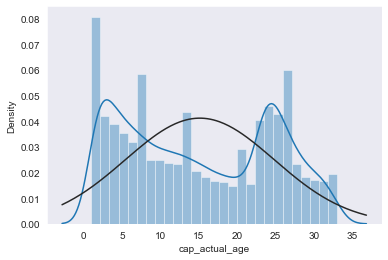

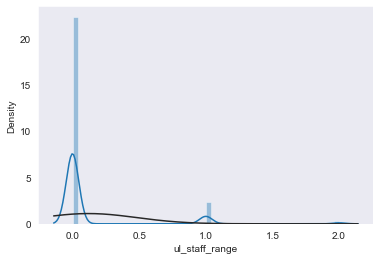

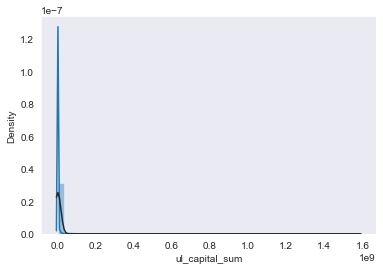

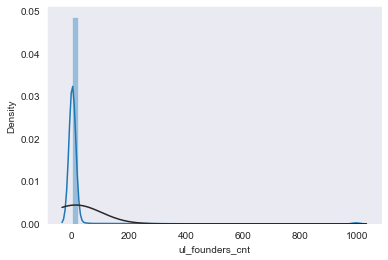

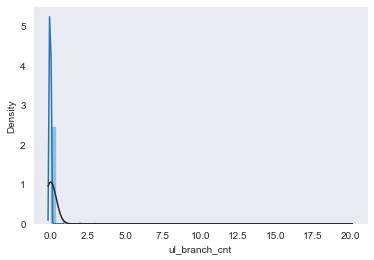

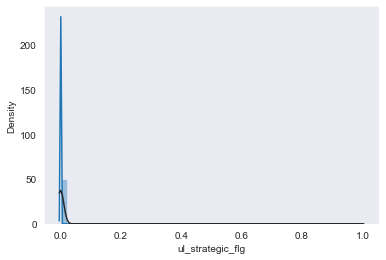

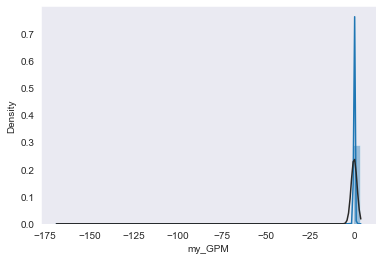

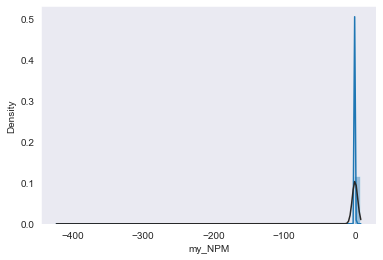

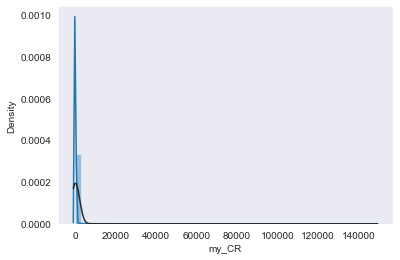

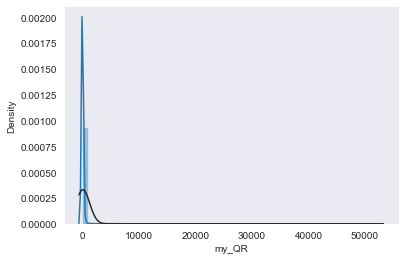

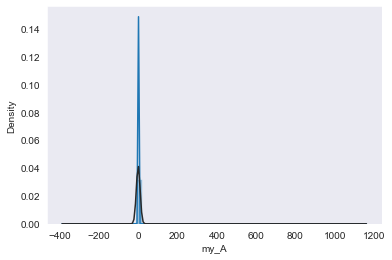

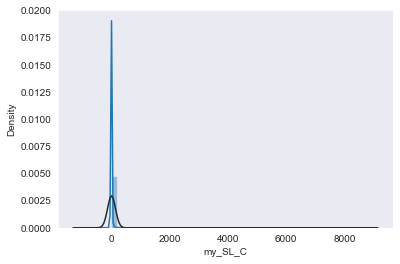

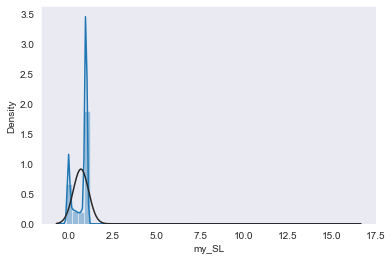

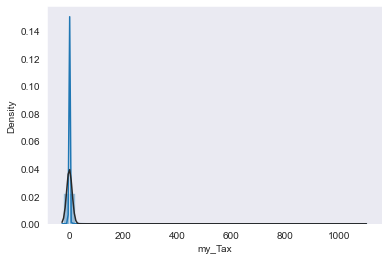

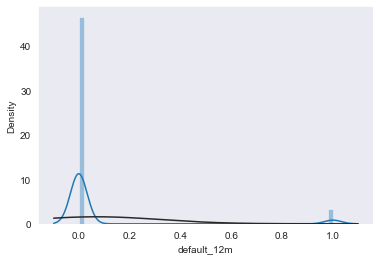

In [2048]:
# Посмотрим на распределение наших данных
from scipy.stats import norm
for col in df_proc_train.columns:
    sns.distplot(df_proc_train[col], fit=norm, kde=True)
    plt.show()

In [2049]:
# Заметно отклонение от нормального распределения у фич, которые имеют невысокие значения, например у 
# ogrn_age. Я решил не проводить логорифмирование, так как далее будет применяться woe трансформация, 
# которая исправит этот мометн

In [2050]:
# Глянем на корреляцию и выведем значения только по назначенному порогу
corr = df_proc_train.corr().values
cols = df_proc_train.shape[1]
cols_name = list(df_proc_train.columns)
for i in range(cols):
    for j in range(i+1, cols):
        if corr[i,j] > 0.7 or corr[i,j] < -0.6:
            print (cols_name[i], ' and ', cols_name[j], ' = ', corr[i,j])

ar_revenue  and  ar_total_expenses  =  0.9879403779750456
ar_revenue  and  ar_sale_cost  =  0.9829034080959907
ar_total_expenses  and  ar_sale_cost  =  0.993685916684876
ar_sale_profit  and  ar_profit_before_tax  =  0.9561162817670048
ar_sale_profit  and  ar_net_profit  =  0.9486855913240136
ar_profit_before_tax  and  ar_net_profit  =  0.9968209279637764
ab_immobilized_assets  and  ab_own_capital  =  0.776916866587575
ab_mobile_current_assets  and  ab_inventory  =  0.8112181345660834
ab_mobile_current_assets  and  ab_accounts_receivable  =  0.7871970465082226
ab_mobile_current_assets  and  ab_borrowed_capital  =  0.8535410233625176
ab_mobile_current_assets  and  ab_accounts_payable  =  0.7335943817277939
ab_inventory  and  ab_borrowed_capital  =  0.7124216714582733
ab_borrowed_capital  and  ab_accounts_payable  =  0.8010376465566388
bus_age  and  ogrn_age  =  0.8369981285036916
adr_actual_age  and  head_actual_age  =  1.0
adr_actual_age  and  cap_actual_age  =  1.0
head_actual_age  and

In [2051]:
# Очень много сильно зависимых значений, где-то даже 1, это необходимо устранить на этапе feature selection

In [2052]:
# Удалим наши id, для обучения они нам не нужны
df_proc_train.drop('record_id', axis=1, inplace=True)
# Пришло время разделить данные на датасеты с финотчетностью и без 
df_ip = df_proc_train[df_proc_train['ar_revenue'].isna()].reset_index(drop=True)
df_no_ip = df_proc_train[~df_proc_train['ar_revenue'].isna()].reset_index(drop=True)

# Бинаризация признаков и обучение

## Модель IP

### Обработка данных модели ip

In [2053]:
# Удалим все признаки где мы имеет NaN значения
df_ip = df_ip.drop(df_ip.iloc[1][df_ip.iloc[1].isna()].index, axis=1)

In [2054]:
# Посмотрим на количество различных значений ранее нас смутившего признака
df_ip['ul_strategic_flg'].value_counts()

0    10215
Name: ul_strategic_flg, dtype: int64

In [2055]:
# Очевидно, что его можно удалить
df_ip.drop('ul_strategic_flg', axis=1, inplace=True)

### Бинаризация модели ip

In [2056]:
# Для построения pd модели необходима бинаризация. Для этого есть прекрасная библиотека riskpy, которая
# поможет сделать woe трансформацию и даже построит графики для анализирования
from riskpy.modeling.binning import Binner
from riskpy.graphs.graphs import binning_barchart

In [2057]:
biner_ip = Binner()
bins = biner_ip.fit(df_ip, 'default_12m')
df_ip_bininig = biner_ip.transform(df_ip)

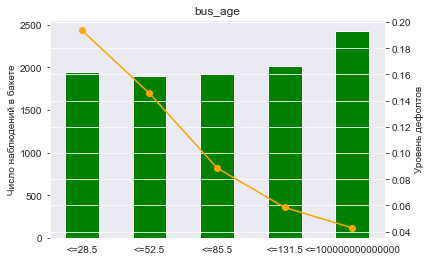

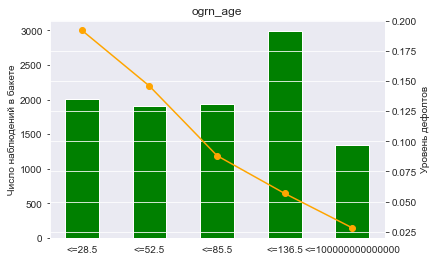

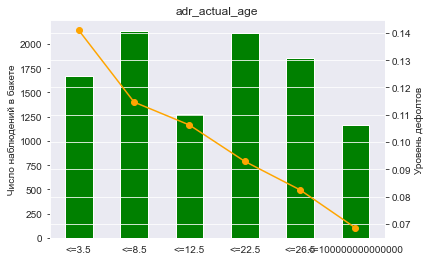

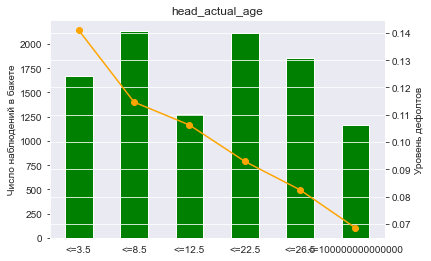

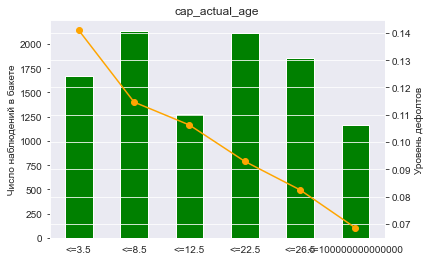

No binning for variable ul_staff_range


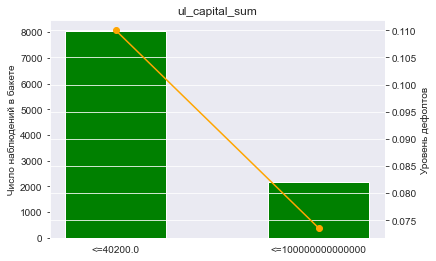

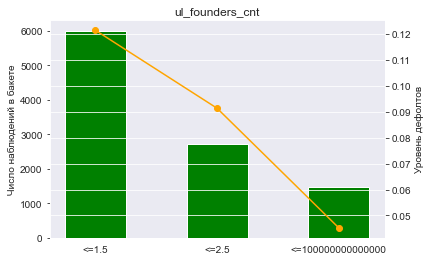

No binning for variable ul_branch_cnt


In [2058]:
binning_barchart(bins)

In [2059]:
# Мы получили оптимальное разбиение, woe монотонно убывает. Теперь выделим таргет и начнем обучение
X_ip_bin = df_ip_bininig.drop('default_12m', axis=1)
y_ip_bin = df_ip_bininig['default_12m']

### Обучение модели ip

In [2060]:
# У нас очень много признаков, которые коррелируют. Я решил провести этап feature importance, что бы 
# исключить большинство признаков, которые не вносят большой импакт в предсказание модели. Для этого
# использовалась библиотека mlxtend. Она хорошо себя показала на этих данных по сравнению с RFS. 
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

clf = LogisticRegression(random_state = 42)
cv = StratifiedKFold(5, shuffle = True, random_state = 42)
# Оптимальное количество фичей я определил равным 4. При большем значении встречается большая корреляция
# или ухудшается скор
feat_selector = SFS(logreg, k_features = 4, forward = True,  scoring ='roc_auc', cv = cv)
feat_selector.fit(X_ip_bin, y_ip_bin)

SequentialFeatureSelector(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                          estimator=LogisticRegression(random_state=42),
                          k_features=(4, 4), scoring='roc_auc')

In [2061]:
drop_col = list(set(X_ip_bin.columns) - set(feat_selector.subsets_[4]['feature_names']))
print("Признаки, которые алгоритм убрал: ", drop_col)

Признаки, которые алгоритм убрал:  ['head_actual_age_woe', 'bus_age_woe', 'cap_actual_age_woe']


In [2062]:
# Удалим выбранные признаки 
X_ip_bin.drop(drop_col, axis=1, inplace=True)

<AxesSubplot:>

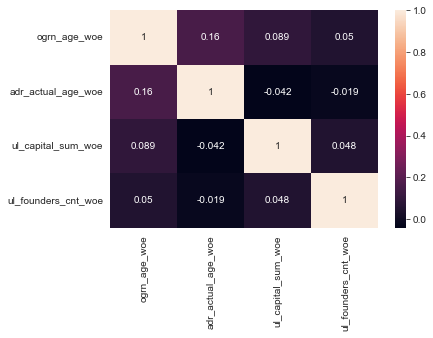

In [2063]:
# Теперь посмотрим на матрицу корреляции
corr = X_ip_bin.corr()
sns.heatmap(corr, annot=True)

In [2064]:
# Отлично! Больше 0.16 значений нет

In [2065]:
# Оценим оставшиеся признаки по Джини
def get_gini(X, y, clf):
    cols = X.columns
    coef_gini = []
    for col in cols:
        one_col = X[col].values.reshape(-1, 1)
        clf.fit(one_col, y)
        gini = 2*roc_auc_score(y, clf.predict_proba(one_col)[:, 1]) - 1
        coef_gini.append(gini)
    gini_res = pd.DataFrame(data=coef_gini, index=cols, columns=['Gini_score'])
    return gini_res['Gini_score'].sort_values(ascending=False)

In [2066]:
clf = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear', penalty='l1')
gini_ip = get_gini(X_ip_bin, y_ip_bin, clf)
gini_ip

ogrn_age_woe           0.347515
ul_founders_cnt_woe    0.141587
adr_actual_age_woe     0.135825
ul_capital_sum_woe     0.066168
Name: Gini_score, dtype: float64

In [2067]:
# Удалим признаки с коэф. Джини меньше 0.1, так как у них маленькая предсказательная способность
X_ip_bin.drop('ul_capital_sum_woe', axis=1, inplace=True)

In [2068]:
# Сделаем отложенную выборку для оценивания модели 
X_ip_bin_train, X_ip_bin_test, y_ip_bin_train, y_ip_bin_test = train_test_split(X_ip_bin, y_ip_bin, 
                                                                               stratify=y_ip_bin,
                                                                               shuffle=True, 
                                                                               random_state=56)

Оптимальное значение C:  3.1724137931034484
Наибольший roc_auc:  0.6916557095443686


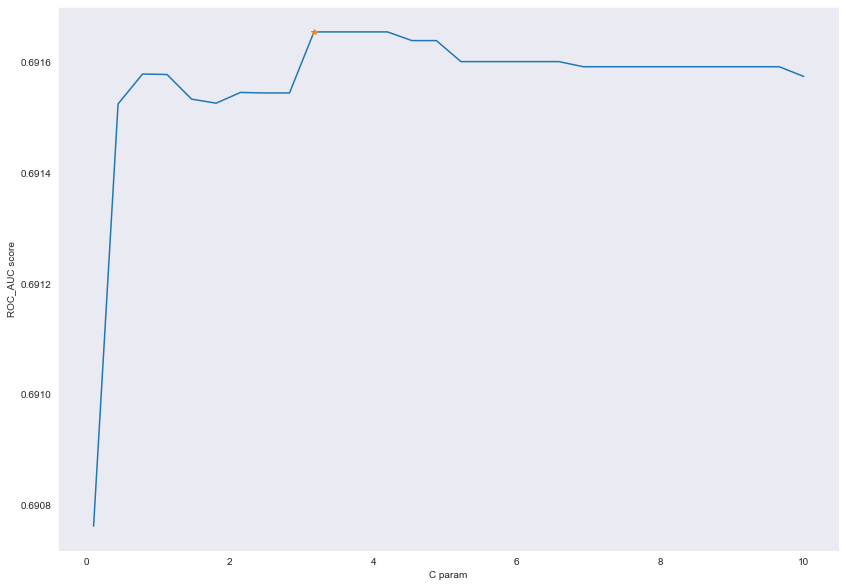

In [2069]:
# Для обучения я выбрал модель логистической регрессии, так как она легко интерпритируема, идеально 
# подходит для бинарной классификации с большим дисбалансом, а также с ней лучше рабоет woe трансформация
# как с линейным алгоритмом который находит только линейные зависимости.

# Подберем оптимальный параметр регуляризации. Так как у нас всего один параметр, я решил не использовать
# GridSearch, чтобы легче было понимать как ведет себя модель.
alphas = np.linspace(0.1, 10, 30)
folds = 5
scores = []
for alpha in alphas:
    cv = StratifiedKFold(folds, shuffle=True, random_state=1)
    clf = LogisticRegression(C=alpha)
    score = cross_val_score(clf, X_ip_bin_train, y_ip_bin_train, cv=cv, scoring='roc_auc')
    scores.append(score.mean())
fig, ax = plt.subplots(figsize = (14, 10))
plt.xlabel("C param")
plt.ylabel("ROC_AUC score")
plt.plot(alphas, scores)
plt.plot(alphas[np.argmax(scores)], np.max(scores), '*')
print('Оптимальное значение C: ', alphas[np.argmax(scores)])
print('Наибольший roc_auc: ', np.max(scores))

In [2070]:
best_model_ip = LogisticRegression(C = alphas[np.argmax(scores)]).fit(X_ip_bin_train, y_ip_bin_train)

In [2071]:
print ('ROC_AUC:  ', round(roc_auc_score(y_ip_bin_test, best_model_ip.predict_proba(X_ip_bin_test)[:,1]), 3))
print ('Gini:     ', round(2*roc_auc_score(y_ip_bin_test, best_model_ip.predict_proba(X_ip_bin_test)[:,1]) - 1, 3))
display(eli5.show_weights(best_model_ip, top=20, feature_names = list(X_ip_bin_test.columns)))

ROC_AUC:   0.728
Gini:      0.455


Weight?,Feature
-0.693,adr_actual_age_woe
-0.896,ogrn_age_woe
-0.910,ul_founders_cnt_woe
-2.163,<BIAS>


In [2072]:
# Мы получили отличные показатели по метрике и джини. Также видим, что наши фичи практически в равной
# степени влияют на предикт модели

## Модель no_IP

### Обработка данных модели no_ip

In [2073]:
df_no_ip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16375 entries, 0 to 16374
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ar_revenue                    16375 non-null  float64
 1   ar_total_expenses             16375 non-null  float64
 2   ar_sale_cost                  16375 non-null  float64
 3   ar_selling_expenses           16375 non-null  float64
 4   ar_management_expenses        16375 non-null  float64
 5   ar_sale_profit                16375 non-null  float64
 6   ar_balance_of_rvns_and_expns  16375 non-null  float64
 7   ar_profit_before_tax          16375 non-null  float64
 8   ar_taxes                      16375 non-null  float64
 9   ar_other_profit_and_losses    16375 non-null  float64
 10  ar_net_profit                 16375 non-null  float64
 11  ab_immobilized_assets         16375 non-null  float64
 12  ab_mobile_current_assets      16375 non-null  float64
 13  a

In [2074]:
# В новых признаках есть значения NaN. Могла быть ситуация 0/0. Изменим NaN значения на 0
df_no_ip.fillna(0, inplace=True)

In [2075]:
df_no_ip.describe()

,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,ar_other_profit_and_losses,...,ul_strategic_flg,my_GPM,my_NPM,my_CR,my_QR,my_A,my_SL_C,my_SL,my_Tax,default_12m
count,1.637500e+04,1.637500e+04,1.637500e+04,1.637500e+04,1.637500e+04,1.637500e+04,1.637500e+04,1.637500e+04,1.637500e+04,1.637500e+04,...,16375.000000,16375.000000,16375.000000,16375.000000,16375.000000,16375.000000,16375.000000,16375.000000,16375.000000,16375.000000
mean,7.985187e+07,7.522855e+07,7.173804e+07,2.407210e+06,1.083309e+06,4.623314e+06,-6.052549e+05,4.018059e+06,4.152474e+05,3.894827e+04,...,0.000183,0.074431,-0.007319,131.270608,73.662746,0.426931,5.660141,0.504332,1.477168,0.047389
std,1.250218e+08,1.204088e+08,1.137228e+08,1.198818e+07,7.873977e+06,1.960520e+07,5.815716e+06,1.965486e+07,1.533049e+06,4.942452e+05,...,0.013535,1.640320,3.816192,2025.498305,1168.704006,9.571394,135.338251,0.489566,9.970803,0.212477
min,0.000000e+00,-7.019840e+08,-5.072780e+08,-3.542900e+07,-1.921670e+08,-9.210000e+07,-7.581800e+07,-5.946600e+07,-1.681000e+07,-1.034000e+07,...,0.000000,-168.000000,-421.000000,-91.050000,-90.860000,-382.500000,-1247.666667,-0.481794,-21.250000,0.000000
25%,9.705000e+06,8.820000e+06,8.466000e+06,0.000000e+00,0.000000e+00,2.060000e+05,-9.080000e+05,1.350000e+05,0.000000e+00,0.000000e+00,...,0.000000,0.017064,0.004475,0.000000,0.000000,0.081803,0.000000,0.000000,1.000000,0.000000
50%,3.129100e+07,2.838600e+07,2.734400e+07,0.000000e+00,0.000000e+00,1.181000e+06,-1.240000e+05,8.050000e+05,4.100000e+04,0.000000e+00,...,0.000000,0.060465,0.022295,1.651272,0.232090,0.359296,0.032279,0.507020,1.119469,0.000000
75%,8.669600e+07,8.126950e+07,7.829250e+07,0.000000e+00,0.000000e+00,4.371500e+06,0.000000e+00,3.374000e+06,2.900000e+05,0.000000e+00,...,0.000000,0.153974,0.077438,6.620841,2.119935,0.719369,0.600097,1.000000,1.254294,0.000000
max,7.946840e+08,7.949360e+08,7.624930e+08,2.746560e+08,3.023550e+08,1.434511e+09,1.584250e+08,1.481526e+09,5.420200e+07,3.979500e+07,...,1.000000,3.144709,6.600000,148668.000000,52709.000000,1156.000000,9080.000000,16.452381,1098.100000,1.000000


In [2076]:
df_no_ip['ul_strategic_flg'].value_counts()

0    16372
1        3
Name: ul_strategic_flg, dtype: int64

In [2077]:
# В данной модели также этот признак не нужен. Удалим его
df_no_ip.drop('ul_strategic_flg', axis=1, inplace=True)

### Бинаризация модели no_ip

In [2078]:
# Здесь делаем все по аналогии с моделью IP
biner_no_ip = Binner()
bins = biner_no_ip.fit(df_no_ip, 'default_12m')
df_no_ip_bininig = biner_no_ip.transform(df_no_ip)

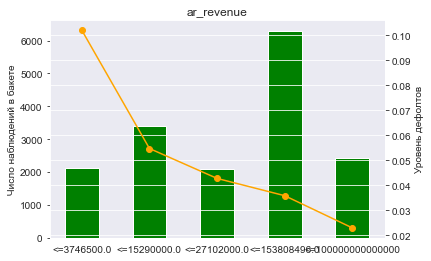

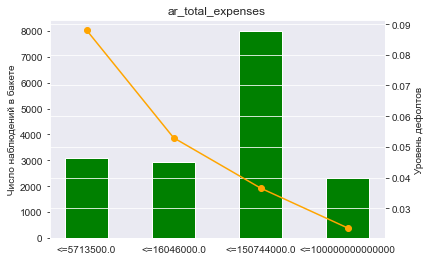

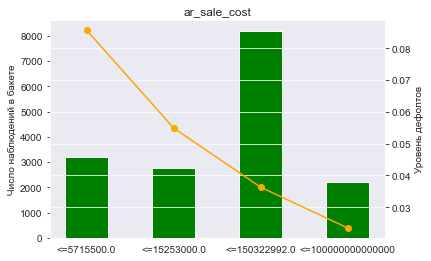

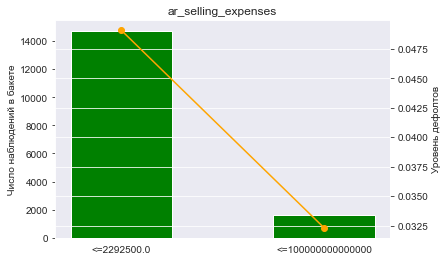

No binning for variable ar_management_expenses


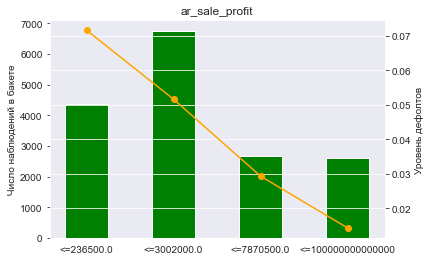

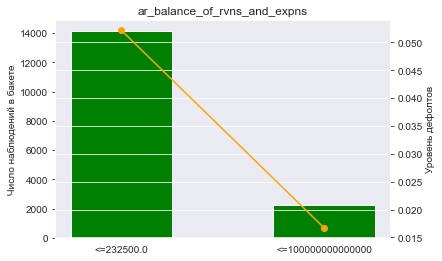

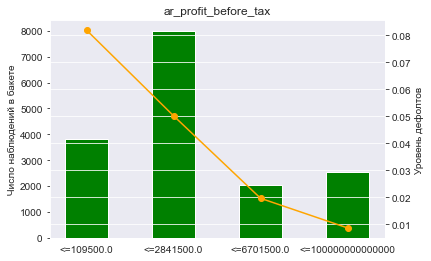

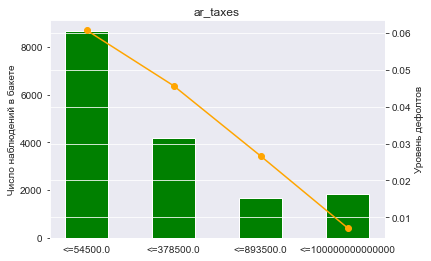

No binning for variable ar_other_profit_and_losses


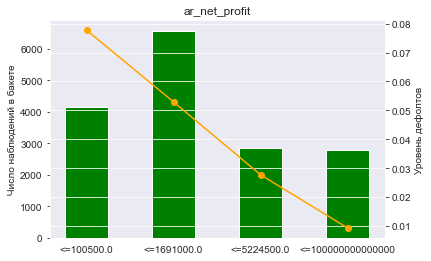

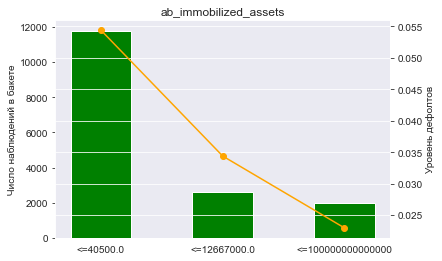

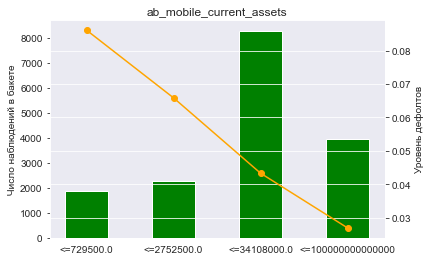

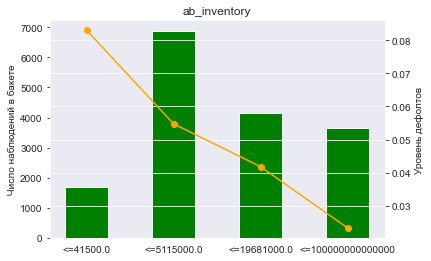

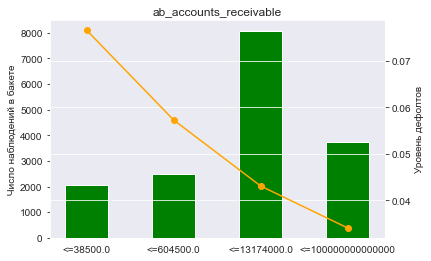

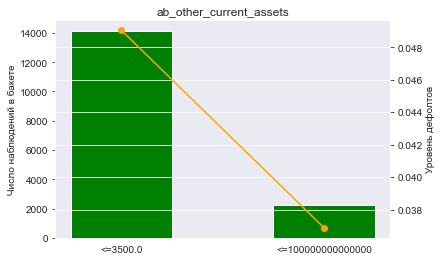

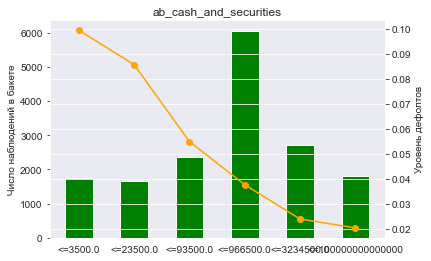

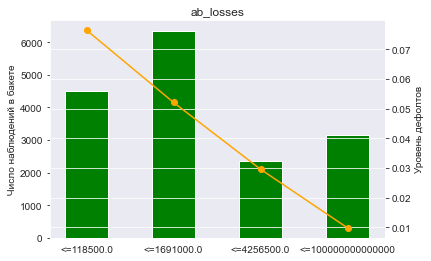

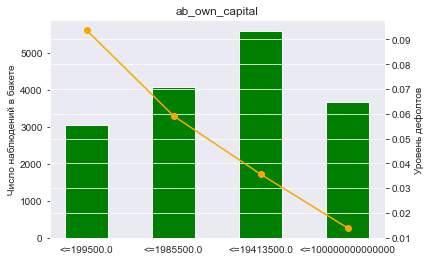

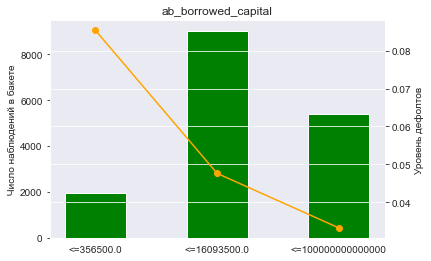

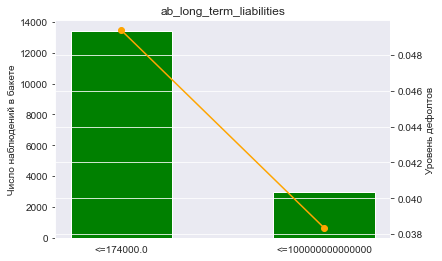

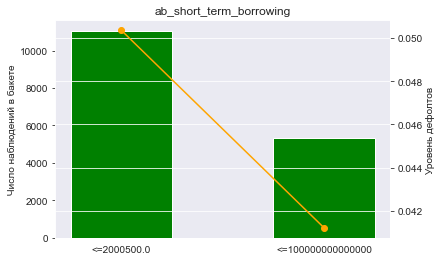

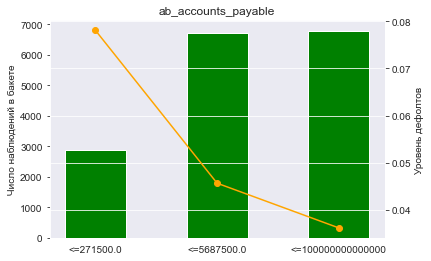

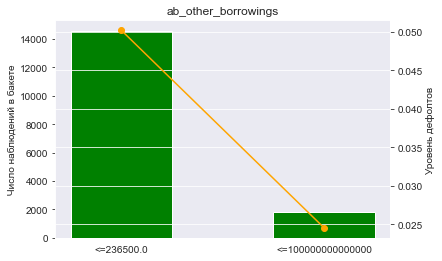

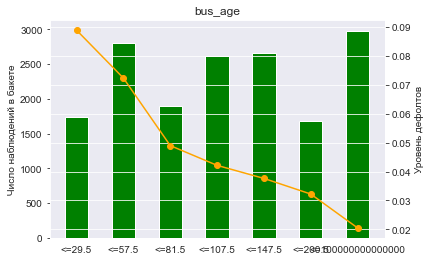

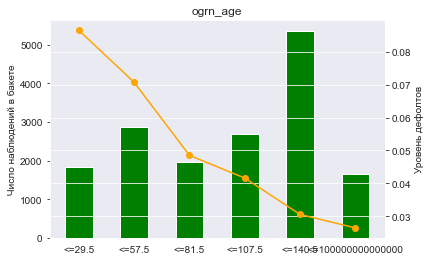

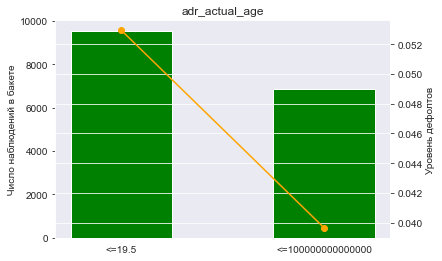

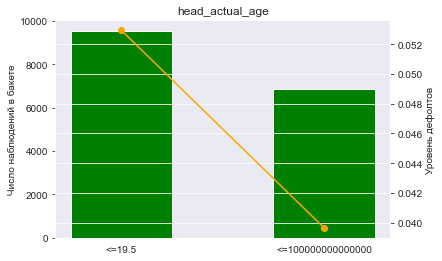

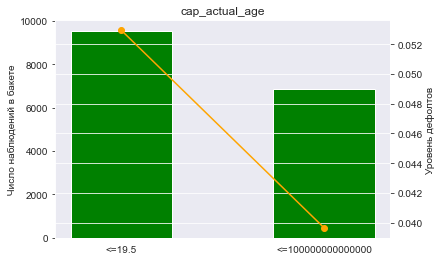

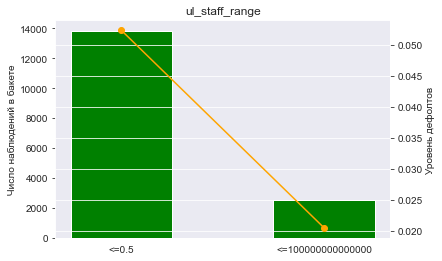

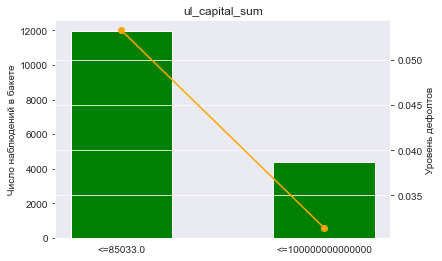

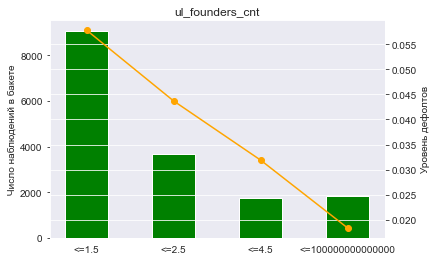

No binning for variable ul_branch_cnt


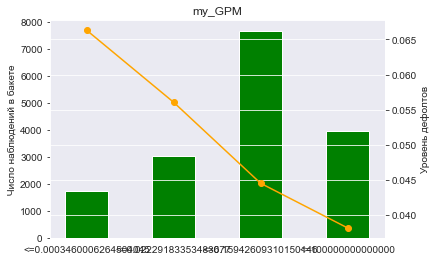

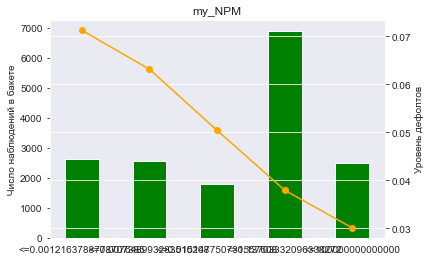

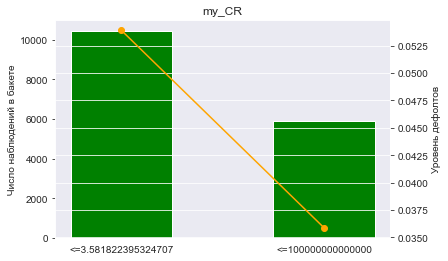

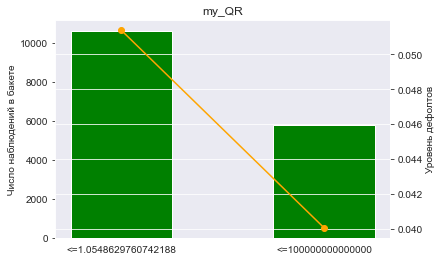

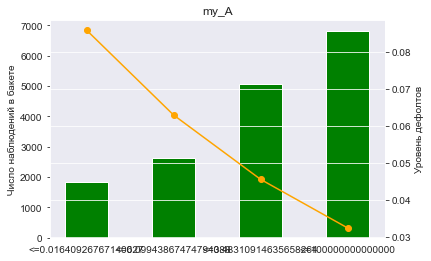

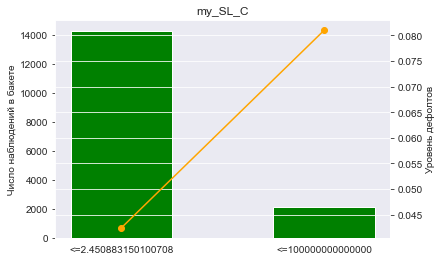

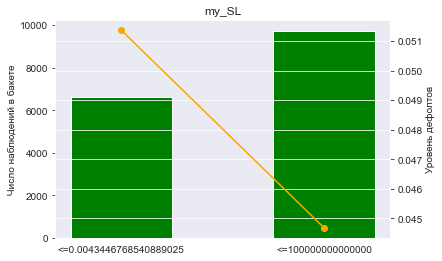

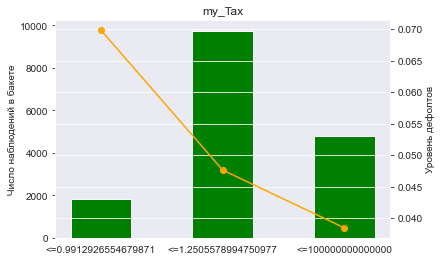

In [2079]:
binning_barchart(bins)

In [2080]:
X_no_ip_bin = df_no_ip_bininig.drop('default_12m', axis=1)
y_no_ip_bin = df_no_ip_bininig['default_12m']

In [2081]:
clf = LogisticRegression(random_state = 42)
cv = StratifiedKFold(5, shuffle = True, random_state = 42)
# Оптимальное количество фичей я определил равным 15. При большем значении встречается большая корреляция
# или ухудшается скор
feat_selector = SFS(logreg, k_features = 15, forward = True,  scoring ='roc_auc', cv = cv)
feat_selector.fit(X_no_ip_bin, y_no_ip_bin)

SequentialFeatureSelector(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                          estimator=LogisticRegression(random_state=42),
                          k_features=(15, 15), scoring='roc_auc')

In [2082]:
drop_col = list(set(X_no_ip_bin.columns) - set(feat_selector.subsets_[15]['feature_names']))
print("Признаки, которые алгоритм убрал: ", drop_col)

Признаки, которые алгоритм убрал:  ['ab_immobilized_assets_woe', 'my_GPM_woe', 'ar_revenue_woe', 'ar_total_expenses_woe', 'ab_losses_woe', 'ar_selling_expenses_woe', 'my_CR_woe', 'ul_staff_range_woe', 'ul_capital_sum_woe', 'ar_sale_cost_woe', 'ab_inventory_woe', 'my_QR_woe', 'ab_long_term_liabilities_woe', 'my_SL_woe', 'my_NPM_woe', 'head_actual_age_woe', 'ab_other_current_assets_woe', 'ar_net_profit_woe', 'ab_mobile_current_assets_woe', 'ab_other_borrowings_woe', 'ab_accounts_payable_woe', 'ogrn_age_woe', 'cap_actual_age_woe']


In [2083]:
X_no_ip_bin.drop(drop_col, axis = 1, inplace=True)

<AxesSubplot:>

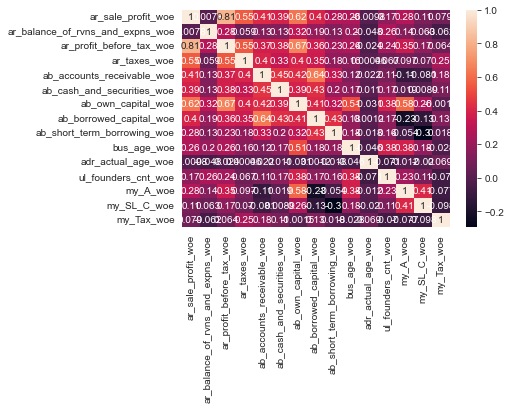

In [2084]:
# Посмотрим на корреляцию оставшихся признаков. Заметна одна сильная корреляция, пока убирать не будем,
# возможно у них маленьких коэф. Джини
corr = X_no_ip_bin.corr()
sns.heatmap(corr, annot=True)

In [2085]:
clf = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear', penalty='l1')
gini_no_ip = get_gini(X_no_ip_bin, y_no_ip_bin, clf)
gini_no_ip

ab_own_capital_woe                  0.327500
ab_cash_and_securities_woe          0.296868
ar_profit_before_tax_woe            0.292926
bus_age_woe                         0.262812
ar_sale_profit_woe                  0.239049
my_A_woe                            0.197828
ar_taxes_woe                        0.196439
ab_borrowed_capital_woe             0.158372
ul_founders_cnt_woe                 0.151808
ab_accounts_receivable_woe          0.145176
my_SL_C_woe                         0.095994
ar_balance_of_rvns_and_expns_woe    0.091944
my_Tax_woe                          0.090725
adr_actual_age_woe                  0.071634
ab_short_term_borrowing_woe         0.044471
Name: Gini_score, dtype: float64

In [2086]:
# Удалим все признаки которые меньше 0.1
X_no_ip_bin.drop(gini_res[gini_res['Gini_score'] < 0.1].index, axis=1, inplace=True)

<AxesSubplot:>

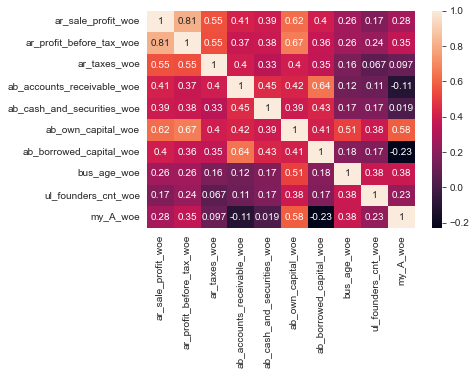

In [2087]:
# Проверим теперь корреляцию
corr = X_no_ip_bin.corr()
sns.heatmap(corr, annot=True)

In [2088]:
# Осталась сильная корреляция, можно ее просто удалить
X_no_ip_bin.drop('ar_sale_profit_woe', axis=1, inplace=True)

### Обучение модели no_IP

In [2089]:
X_no_ip_bin_train, X_no_ip_bin_test, y_no_ip_bin_train, y_no_ip_bin_test = train_test_split(X_no_ip_bin, 
                                                                                            y_no_ip_bin, 
                                                                               stratify=y_no_ip_bin,
                                                                               shuffle=True, 
                                                                               random_state=42)

Оптимальное значение C:  1.0351282051282051
Наибольший roc_auc:  0.7098851481338968


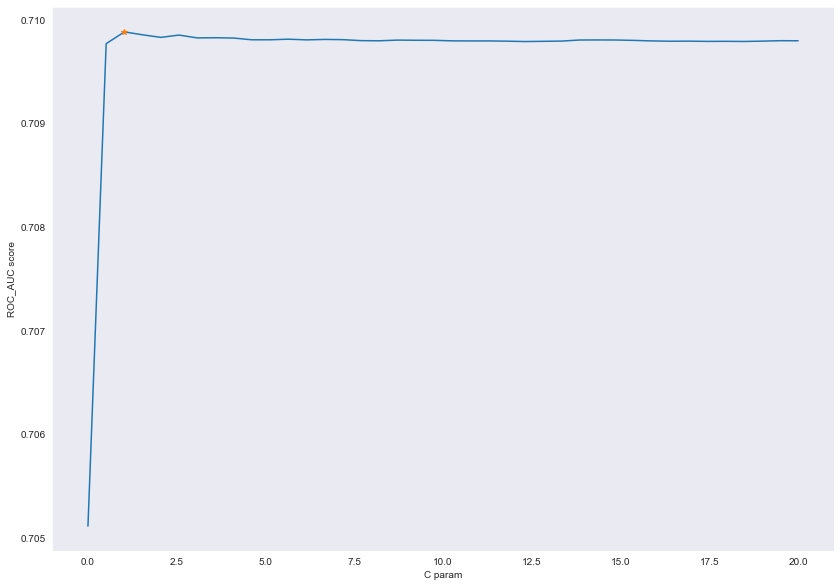

In [2090]:
alphas = np.linspace(0.01, 20, 40)
folds = 5
scores = []
for alpha in alphas:
    cv = StratifiedKFold(folds, shuffle=True, random_state=1)
    clf = LogisticRegression(C=alpha)
    score = cross_val_score(clf, X_no_ip_bin_train, y_no_ip_bin_train, cv=cv, scoring='roc_auc')
    scores.append(score.mean())
fig, ax = plt.subplots(figsize = (14, 10))
plt.xlabel("C param")
plt.ylabel("ROC_AUC score")
plt.plot(alphas, scores)
plt.plot(alphas[np.argmax(scores)], np.max(scores), '*')
print('Оптимальное значение C: ', alphas[np.argmax(scores)])
print('Наибольший roc_auc: ', np.max(scores))

In [2091]:
best_model_no_ip = LogisticRegression(C = alphas[np.argmax(scores)]).fit(X_no_ip_bin_train, y_no_ip_bin_train)

In [2092]:
print ('ROC_AUC:  ', round(roc_auc_score(y_no_ip_bin_test, best_model_no_ip.predict_proba(X_no_ip_bin_test)[:,1]), 3))
print ('Gini:     ', round(2*roc_auc_score(y_no_ip_bin_test, best_model_no_ip.predict_proba(X_no_ip_bin_test)[:,1]) - 1, 3))
display(eli5.show_weights(best_model_no_ip, top=20, feature_names = list(X_no_ip_bin_test.columns)))

ROC_AUC:   0.728
Gini:      0.455


Weight?,Feature
+0.389,ab_accounts_receivable_woe
-0.025,ab_own_capital_woe
-0.192,ab_borrowed_capital_woe
-0.233,ul_founders_cnt_woe
-0.378,ar_profit_before_tax_woe
-0.401,ar_taxes_woe
-0.437,bus_age_woe
-0.473,my_A_woe
-0.737,ab_cash_and_securities_woe
-3.008,<BIAS>


In [2093]:
# Скор меня вполне устраивает, как и коэф. Джини. Интересно что фича own_capital имеет самый маленький
# вес при том, что у нее самый большой коэф. Джини.

# Подготовка тестового датасета

In [2094]:
# Сделаем все преобразования которые мы проводили с нашими тестовыми данными
df_test_ip = df_proc_test[df_proc_test['ar_revenue'].isna()]
df_test_no_ip = df_proc_test[~df_proc_test['ar_revenue'].isna()]

df_test_no_ip = df_test_no_ip.replace([-np.inf, np.inf], 0)
df_test_no_ip = df_test_no_ip.fillna(0)

# Запомним наши record id чтобы потом соеденить наши предикты
record_id_ip = df_test_ip['record_id']
record_id_no_ip = df_test_no_ip['record_id']

In [2095]:
# woe трансформер требует наличия таргета, но у тестовых данных его нет, поэтому создадим столбец "для галочки"
df_test_ip['default_12m'] = np.NaN
df_test_no_ip['default_12m'] = np.NaN

In [2096]:
# Сделаем трансформацию и замомним только наши ранее выбранные фичи
df_test_ip = biner_ip.transform(df_test_ip[df_ip.columns])[X_ip_bin.columns]
df_test_no_ip = biner_no_ip.transform(df_test_no_ip[df_no_ip.columns])[X_no_ip_bin.columns]

# Финальный предикт

In [2097]:
# Для выбора catoff я решил просто взять вероятность класса 1
cut_off_ip = df_ip['default_12m'].sum()/int(df_ip.shape[0])
cut_off_no_ip = df_no_ip['default_12m'].sum()/int(df_no_ip.shape[0])
print("Cut_off с фин отчетностью:", cut_off_ip)
print("Cut_off без фин отчетности:", cut_off_no_ip)

Cut_off с фин отчетностью: 0.10230053842388644
Cut_off без фин отчетности: 0.04738931297709924


In [2098]:
# Экспериметально был добавлен небольшой сдвиг для cutoff
y_pred_ip = best_model_ip.predict_proba(df_test_ip)[:,1]
predict_ip = (y_pred_ip > cut_off_ip + 0.01).astype(int)

In [2099]:
y_pred_no_ip = best_model_no_ip.predict_proba(df_test_no_ip)[:,1]
predict_no_ip = (y_pred_no_ip > cut_off_no_ip + 0.008).astype(int)

In [2100]:
# Соединим наши предикты двух моделей
ans_ip = dict(zip(record_id_ip, predict_ip))
ans_no_ip = dict(zip(record_id_no_ip, predict_no_ip))
ans_dict = ans_ip.copy()
ans_dict.update(ans_no_ip)

In [2101]:
submit = test_df[['record_id']]
submit['predict'] = submit['record_id']
submit['predict'] = submit['predict'].map(ans_dict)
submit = submit.rename(columns = {'record_id': 'id'})

In [2102]:
submit.to_csv('my_submit.csv',index=False, sep=';')